In [1]:
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 260 (delta 61), reused 49 (delta 49), pack-reused 163
Receiving objects: 100% (260/260), 53.29 MiB | 53.71 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=0fe05a2445e0e5f1f36d6b3dace5e9d8ac66da55ea1cfdc9f8f08399af18151c
  Stored in directory: /tmp/pip-ephem-wheel-cache-e322n9xv/wheels/fc/bf/3f/aec14efe68065aec0e4aa8b0751e810e1b81104fa57bb6ffe6
Successfully built dul-2021


In [3]:
from dul_2021.utils.hw7_utils import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
!nvidia-smi

Tue Dec 21 22:32:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1A.0 Off |                    0 |
| N/A   45C    P0    60W / 300W |   8834MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


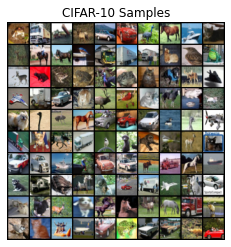

In [6]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [39]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal
from torchvision import transforms
from tqdm import tqdm
import numpy as np

In [40]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4)
        output = output.reshape(batch_size, s_height, s_width, s_depth).permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output


# Spatial Upsampling with Nearest Neighbors
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            DepthToSpace(block_size=2),
            nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=True)
        )
        
    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        return self.block(x)


# Spatial Downsampling with Spatial Mean Pooling
class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.space_to_depth = SpaceToDepth(block_size=2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=True)

    def forward(self, x):
        out = self.space_to_depth(x)
        out = sum(out.chunk(4, dim=1)) / 4.0
        return self.conv(out)

In [41]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.up1 = nn.Sequential(
            nn.BatchNorm2d(in_dim), 
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1, bias=True),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        )

        self.up2 = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        out = self.up1(x)
        skip = out + self.up2(x)
        return skip

class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.down1 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1, bias=True),
            nn.ReLU(),
            Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        )

        self.down2 = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        out = self.down1(x)
        skip = out + self.down2(x)
        return skip

In [42]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)


class Generator(nn.Module):
    def __init__(self, n_filters=128, latent_size=128):
        super().__init__()
        self.latent_size = 128
        self.model = nn.Sequential(
            nn.Linear(128, 4 * 4 * 256),
            View((-1, 256, 4, 4)),
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, n_filters=128, latent_size=128):
        super().__init__()
        self.latent_size = 128
        self.model = nn.Sequential(
            ResnetBlockDown(in_dim=3, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            nn.ReLU(),
            View((-1, 512)),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        out = self.model(x)
        return out
        

In [43]:
class WGANGP(nn.Module):
    def __init__(self, latent_size=128, lr=2e-4):
        super().__init__()
        self.netG = Generator()
        self.netD = Discriminator()
        self.latent_size = latent_size

        self.optimizer_netD = torch.optim.Adam(self.netD.parameters(), 
                                               lr=lr, 
                                               betas=(0, 0.9))
        
        self.optimizer_netG = torch.optim.Adam(self.netG.parameters(), 
                                               lr=lr, 
                                               betas=(0, 0.9))
        
#         self.scheduler_G = torch.optim.lr_scheduler.StepLR(
#             self.optimizer_netG,
#             step_size=10,
#             gamma=0.9, 
#             last_epoch=-1
#         )

        n_iter = 4000
        lambda1 = lambda epoch: (n_iter - epoch) / n_iter

        self.scheduler_G = torch.optim.lr_scheduler.LambdaLR(self.optimizer_netG,
                                    lambda1,
                                    last_epoch=-1)
    
        self.scheduler_D = torch.optim.lr_scheduler.LambdaLR(self.optimizer_netD,
                                    lambda1,
                                    last_epoch=-1)

#         self.scheduler_D = torch.optim.lr_scheduler.StepLR(
#             self.optimizer_netD,
#             step_size=10,
#             gamma=0.9, 
#             last_epoch=-1
#         )
         
        self.lambda_gp = 10
        self.device = device
        self.losses = []

    def forward(self, z):
        fake = self.netG(z)
        return fake

    def optimize_params_D(self, real):
        self.optimizer_netD.zero_grad()
        
        self._bs = real.shape[0]
        z = Normal(0, 1).sample([self._bs, self.latent_size]).to(device)
        
        fake = self.netG(z)
        
        # Gradient penalty
        loss_GP = self._gradient_penalty_D(self.netD, fake, real)

        pred_real = self.netD(real)
        pred_fake = self.netD(fake)
        loss = -torch.mean(pred_real) + torch.mean(pred_fake) + self.lambda_gp * loss_GP

        loss.backward()
        self.optimizer_netD.step()

        self.losses.append(loss.item())

    def optimize_params_G(self):
        self.optimizer_netG.zero_grad()
        
        z = Normal(0, 1).sample([self._bs, self.latent_size]).to(device)

        fake = self.netG(z)
        
        pred_fake = self.netD(fake)
        loss = -torch.mean(pred_fake)

        loss.backward()
        self.optimizer_netG.step()

    def _gradient_penalty_D(self, netD, fake, real):
        # interpolate sample
        bs = fake.shape[0]

        alpha = torch.rand(bs, 1, 1, 1).expand_as(fake).to(self.device)
        interpolated = alpha * real + (1 - alpha) * fake
        interpolated._requires_grad = True
        pred_interpolated = netD(interpolated)
        
        # compute gradients
        grad = torch.autograd.grad(
            outputs=pred_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(pred_interpolated.size()).to(self.device),
            retain_graph=True,
            create_graph=True,
            only_inputs=True,
        )[0]

        # penalize gradients
        grad = grad.reshape(bs, -1)
        loss_d_gp = torch.mean((grad.norm(dim=1) - 1) ** 2)
        return loss_d_gp
        

In [44]:
class CustomDataset(Dataset):
    def __init__(self, train_data):
        self.transform = transforms.Normalize((0.5,), (0.5,))
        self.data = train_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = torch.Tensor(self.data[idx])
        img = self.transform(img)
        return img

In [45]:
def train(model, train_data, n_critic=5, latent_size=128, lr=2e-4, batch_size=256, epochs=20):
    # 𝛼=2𝑒−4 , 𝛽1=0, 𝛽2=0.9, 𝜆=10, 𝑛𝑐𝑟𝑖𝑡𝑖𝑐 = 5
    train_dataset = CustomDataset(train_data)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in tqdm(range(epochs)):
        for i, batch in enumerate(iter(trainloader)):
            real_imgs = batch.to(device)
            
            model.optimize_params_D(real_imgs)

            if i % n_critic == 0:
                model.optimize_params_G()
                model.scheduler_G.step()
                model.scheduler_D.step()

    return np.array(model.losses)

In [46]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    latent_size=128
    model = WGANGP(latent_size=latent_size).to(device)

    losses = train(model, train_data, batch_size=512, epochs=60)
    
    model.netG.eval()
    with torch.no_grad():
        samples = np.empty((1000, 32, 32, 3))
        for i in range(5):
            z = Normal(0, 1).sample([200, latent_size]).to(device)
            samples[i * 200 : (i+1) * 200] = model(z).add(1).div(2).permute(0, 2, 3, 1).detach().cpu().numpy()
    
    return losses, samples

## Results

Files already downloaded and verified


100% 60/60 [46:04<00:00, 46.08s/it]


..........Inception score: 5.505407


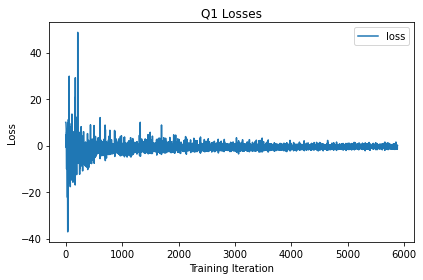

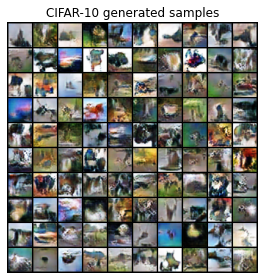

In [49]:
q1_save_results(q1)

Files already downloaded and verified
196


100% 20/20 [14:48<00:00, 44.44s/it]


..........Inception score: 3.7271


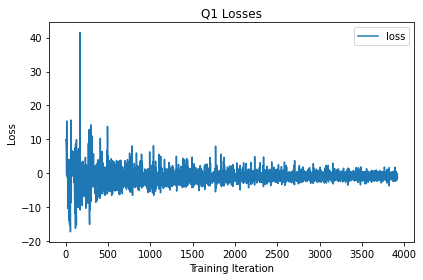

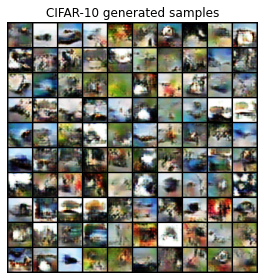

In [86]:
q1_save_results(q1)

Files already downloaded and verified
98


100% 30/30 [17:00<00:00, 34.01s/it]


..........Inception score: 3.8849761


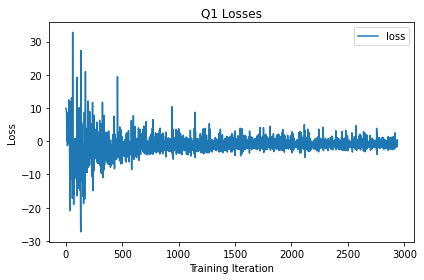

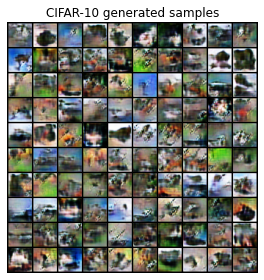

In [88]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


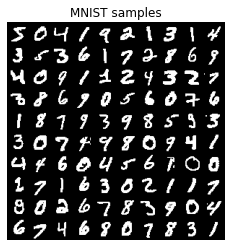

In [7]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [21]:
# In all permutation-invariant MNIST experiments (Section 4.2), D, G, and E each consist of two
# hidden layers with 1024 units. The first hidden layer is followed by a non-linearity; the second is
# followed by (parameter-free) batch normalization (Ioffe & Szegedy, 2015) and a non-linearity. The
# second hidden layer in each case is the input to a linear prediction layer of the appropriate size. In D
# and E, a leaky ReLU (Maas et al., 2013) non-linearity with a “leak” of 0.2 is used; in G, a standard
# ReLU non-linearity is used. All models are trained for 400 epochs.

class Discriminator(nn.Module):
    def __init__(self, latent_size=50):
        super().__init__() 
        self.latent_size = latent_size
        
        self.model = nn.Sequential(
            nn.Linear(784 + self.latent_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x, z):
        out = self.model(torch.cat((x.view(-1, 784), z), dim=1))
        return out
    

class Generator(nn.Module):
    def __init__(self, latent_size=50):
        super().__init__()
        self.latent_size = latent_size
        
        self.model = nn.Sequential(
            nn.Linear(self.latent_size, 1024),
            nn.ReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
            View((-1, 1, 28, 28)),
        )
        
    def forward(self, z):
        fake = self.model(z)
        return fake


class Encoder(nn.Module):
    def __init__(self, latent_size=50):
        super().__init__()
        self.latent_size = latent_size
        
        self.model = nn.Sequential(
            View((-1, 784)),
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.latent_size),
        )
        
    def forward(self, x):
        z_pred = self.model(x)
        return z_pred

In [22]:
class BiGAN(nn.Module):
    def __init__(self, latent_size=50, lr=2e-4):
        super().__init__()
        
        self.latent_size = latent_size
        
        self.netD = Discriminator(latent_size)
        self.netG = Generator(latent_size)
        self.netE = Encoder(latent_size)
        
        self.optimizer_netD = torch.optim.Adam(self.netD.parameters(), 
                                               lr=lr, 
                                               betas=(0, 0.9), 
                                               weight_decay=1e-4)
        
        self.optimizer_netG = torch.optim.Adam(self.netG.parameters(), 
                                               lr=lr, 
                                               betas=(0, 0.9),
                                               weight_decay=1e-4)
        
        self.optimizer_netE = torch.optim.Adam(self.netE.parameters(), 
                                               lr=lr, 
                                               betas=(0, 0.9),
                                               weight_decay=1e-4)
        
        n_iter = 24000
        lambda1 = lambda epoch: (n_iter - epoch) / n_iter
        self.scheduler_D = torch.optim.lr_scheduler.LambdaLR(self.optimizer_netD,
                                                            lambda1,
                                                            last_epoch=-1)
        
        self.scheduler_G = torch.optim.lr_scheduler.LambdaLR(self.optimizer_netG,
                                                            lambda1,
                                                            last_epoch=-1)
        
        self.scheduler_E = torch.optim.lr_scheduler.LambdaLR(self.optimizer_netE,
                                                             lambda1,
                                                             last_epoch=-1)
        
        self.losses = []
        
        
    def optimize_params_D(self, real):
        self.optimizer_netD.zero_grad()
        
        bs = real.shape[0]
        
        z_real = self.netE(real)
        z_fake = Normal(0, 1).sample([bs, self.latent_size]).to(device)
        fake = self.netG(z_fake)
        
        pred_real = self.netD(real, z_real)
        pred_fake = self.netD(fake, z_fake)
        
        loss = - 0.5 * (pred_real.log().mean() + (1 - pred_fake).log().mean())

        loss.backward()
        self.optimizer_netD.step()

        self.losses.append(loss.item())

        
    def optimize_params_G(self, real):
        self.optimizer_netG.zero_grad()
        self.optimizer_netE.zero_grad()
        
        bs = real.shape[0]
        
        z_real = self.netE(real)
        z_fake = Normal(0, 1).sample([bs, self.latent_size]).to(device)
        fake = self.netG(z_fake)
        
        pred_real = self.netD(real, z_real)
        pred_fake = self.netD(fake, z_fake)
        
        loss = 0.5 * (pred_real.log().mean() + (1 - pred_fake).log().mean())

        loss.backward()
        self.optimizer_netG.step()
        self.optimizer_netE.step()
        
        
    def representation(self, x):
        self.netE.eval()
        with torch.no_grad():
            z = self.netE(x)
        return z
    
    
    def reconstruction(self, x):
        self.netG.eval()
        with torch.no_grad():
            z = self.representation(x)
            x_pred = self.netG(z).add(1).div(2).permute(0, 2, 3, 1).detach().cpu().numpy()
        return x_pred
    
    def sample(self, n=100):
        self.netG.eval()
        with torch.no_grad():
            z = Normal(0, 1).sample([n, self.latent_size]).to(device)
            samples = self.netG(z).add(1).div(2).permute(0, 2, 3, 1).detach().cpu().numpy()
            
        return samples


In [23]:
class LinearClassifier(nn.Module):
    def __init__(self, encoder=None, n_classes=10):
        super().__init__()
        
        self.n_classes = n_classes
        self.encoder = encoder if encoder is not None else Encoder(50)
        self.encoder.eval()
        
        self.fc = nn.Linear(50, self.n_classes)
        
    def forward(self, x):
        out = self.encoder(x).detach()
        out = self.fc(out)
        return out
    
    def loss(self, x, y):
        y_pred = self.forward(x)
        return F.cross_entropy(y_pred, y)


def train_classifier(model, train_data, test_data, epochs=100, batch_size=128):
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_data, batch_size=batch_size)
    
    test_losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in tqdm(range(epochs)):
        for x, y in trainloader:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            
            loss = model.loss(x, y)
            
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            total_loss = 0
            tc = 0
            for x, y in testloader:
                loss = model.loss(x.to(device), y.to(device)).item()
                total_loss += loss * x.shape[0]
                tc += x.shape[0]
            test_losses.append(total_loss / tc)
            
        model.train()
        
    return np.array(test_losses)

## Solution

In [24]:
def train(model, train_data, latent_size=50, lr=2e-4, batch_size=128, epochs=100):
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    for epoch in tqdm(range(epochs)):
        for i, (batch, y) in enumerate(iter(trainloader)):
            real_imgs = batch.to(device)
            model.optimize_params_D(real_imgs)
            model.optimize_params_G(real_imgs)
            
            model.scheduler_G.step()
            model.scheduler_D.step()
            model.scheduler_E.step()

    return np.array(model.losses)

In [27]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    
    gan_model = BiGAN(latent_size=50).to(device)
    gan_losses = train(gan_model, train_data, epochs=50, batch_size=512)
    
    samples = gan_model.sample(100)
    
    x_rec_real, _ = next(iter(DataLoader(test_data, batch_size=20)))
    x_rec_fake = gan_model.reconstruction(x_rec_real.to(device))
    x_rec_real = x_rec_real.add(1).div(2).permute(0, 2, 3, 1).detach().cpu().numpy() 
    reconstructions = np.concatenate((x_rec_real, x_rec_fake), axis=0)
    
    rand_enc_classifier = LinearClassifier().to(device)
    rand_enc_losses = train_classifier(rand_enc_classifier, train_data, test_data, epochs=10)
    
    bigan_enc_classifier = LinearClassifier(encoder=gan_model.netE).to(device)
    bigan_enc_losses = train_classifier(bigan_enc_classifier, train_data, test_data, epochs=10)
    
    return gan_losses, samples, reconstructions, bigan_enc_losses, rand_enc_losses


## Results

100% 50/50 [17:19<00:00, 20.79s/it]
100% 10/10 [02:41<00:00, 16.10s/it]
100% 10/10 [02:45<00:00, 16.53s/it]


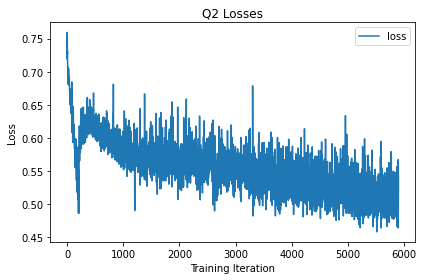

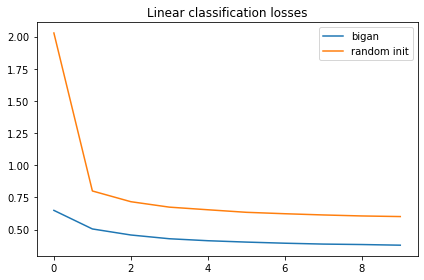

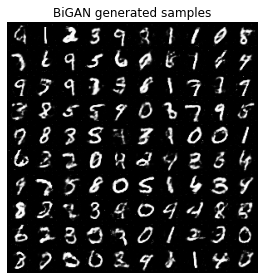

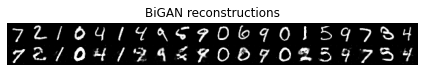

BiGAN final linear classification loss: 0.37891924438476565
Random encoder linear classification loss: 0.6014568583011627


In [28]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

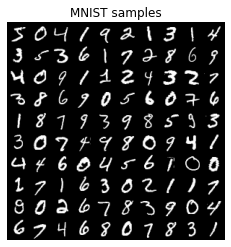

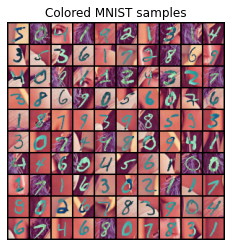

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

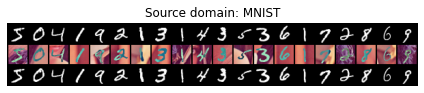

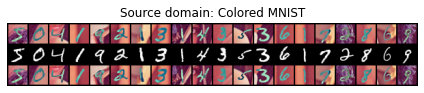

In [ ]:
b5_save_results(b5)